In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from CloudSaturation import CloudSaturation

# Configurator is awailable on
# https://apps.sentinel-hub.com/configurator/#/configurations
# username: koprivec.filip@gmail.com
# password: stefanpass

# If major edits are in order, just create new WMS instance (dont forget to update instanceid)


/Users/joosko/work/ijs/ml/SentinelHub/venv/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))


In [3]:
def plot_cloud_mask(mask, figsize=(15,15), cmap="gray", normalize=False, plot_cmap=False, cmap_frac=0):
    """
    Utility function for plotting a binary cloud mask.
    """
    plt.figure(figsize=figsize)
    plot = plt.subplot(1, 1, 1)
    if not normalize:
        vmin_vmax = {"vmin":0, "vmax":1}
    else:
        vmin_vmax = dict()
    pl = plot.imshow(mask, cmap=cmap, **vmin_vmax)
    if plot_cmap:
        #Legend
        def fmt(x, pos):
            return "{} %".format(int(round(x*100)))
        cbar = plt.colorbar(pl, format=ticker.FuncFormatter(fmt),fraction=cmap_frac or 1, pad=0.04)
        cbar.set_label("Clud saturation")
    # Todo: plot nice cmap

def plot_image(data, factor=1./255, cmap=None):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting 
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    rgb = data.astype(np.float32)
    if len(rgb.shape) == 3 and rgb.shape[2] == 3:
        rgb = rgb[..., [2, 1, 0]]
    plt.imshow(rgb * factor, cmap=cmap)
    

def plot_timeseries(data, factor=1./255, cmap="gray"):
    """
    Utility function for ploting timeseries type data.
    """
    
    
    return plot_image(np.array([data]), cmap=cmap)


def plot_timeseries_line(data, vis, spec="ro", new=True, datesp=None):
    if new:
        fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
        if datesp is not None:
            def ext_month(a):
                return f"{a.day}.{a.month}.{a.year}"
            xt = list(map(ext_month, datesp))
            k = 10
            filt = np.arange(0,len(datesp), k)
            plt.xticks(filt,xt[0::k])
    plt.plot(vis[0], data[vis], spec)
    
def get_timeseries_delete(mask, true_c, bands, dates, cloud_masks, x_ind, y_ind, band_ind):
    # Filter images
    # Choose 0 band as reference for non photographed
    nonzero_image_indices = np.nonzero(bands[:,x_ind, y_ind, 0])
    nonzero_cloud_indices = np.nonzero(cloud_masks[:,x_ind, y_ind])
    both_nonzero = np.intersect1d(nonzero_image_indices, nonzero_cloud_indices)
    
    return bands[both_nonzero, x_ind, y_ind, band_ind], dates[both_nonzero]

def convert_to_dd(degms):
    deg, other = degms.split("°")
    minn, other = other.split("'")
    sec, way = other.split('"')
    
    return (float(deg) + float(minn)/60 + float(sec)/3600) * [-1,1][way=="N" or way=="E"]

def overlay_cloud_mask(image, mask=None, factor=1./255, nrows=1, ncols=1, figsize=(15, 15)):
    """
    Utility function for plotting RGB images with binary mask overlayed. The numpy arrays returned 
    by the Sentinel Hub's WMS and WCS requests have channels ordered as Blue (`B02`), Green (`B03`), 
    and Red (`B04`) therefore the order has to be reversed before ploting the image.
    """
    plt.subplots(nrows, ncols, figsize=figsize, frameon=False)
    rgb = np.zeros(image.shape, dtype=np.uint8)
    rgb = image[..., [2, 1, 0]]

    plt.imshow(rgb * factor)
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([255,255,0,100], dtype=np.uint8)
        plt.imshow(cloud_image)

In [3]:
# Requesting size of Slovenia BB results in error "The bounding box area is too large! Please zoom in."
tulip_box = [52.89906593845727, 4.71038818359375,52.95205098150524, 4.798278808593751]
home_box = [45.96916667, 14.31472222, 46.03416667, 14.35972222]
kocevje_box = [convert_to_dd("""45°34'52.69"N"""), convert_to_dd("""14°49'23.05"E"""),convert_to_dd("""45°36'34.31"N"""), convert_to_dd("""14°52'29.75"E""")]
#tulip_box = home_box
cloud_sat = CloudSaturation(tulip_box, cloud_scale=2)
kocevje_cloud = CloudSaturation(kocevje_box)
# This bounding box is also small enough so that all images are from the same tile -> no problems with cut-off

In [4]:
mask, true_c, bands, dates, cloud_masks = cloud_sat.get_cloud_saturation_mask()


Saved True color
Saved bands
Saved bands
Downloaded
(300, 298)
Detected
(119, 600, 596)
(119, 589, 589)
(589, 589, 3)


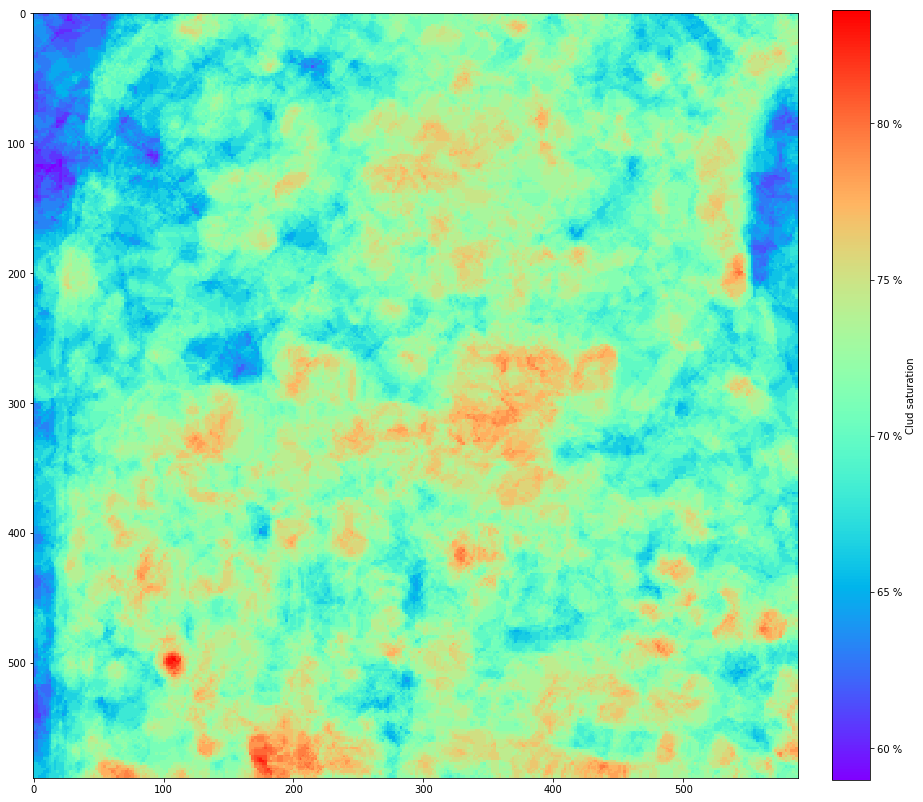

In [5]:
plot_cloud_mask(mask, cmap="rainbow", plot_cmap=True, cmap_frac=0.046, normalize=True)
plt.savefig("netherlands_cloud_saturation_cloud_scale_2_normalized", bbox_inches='tight', pad_inches=0)

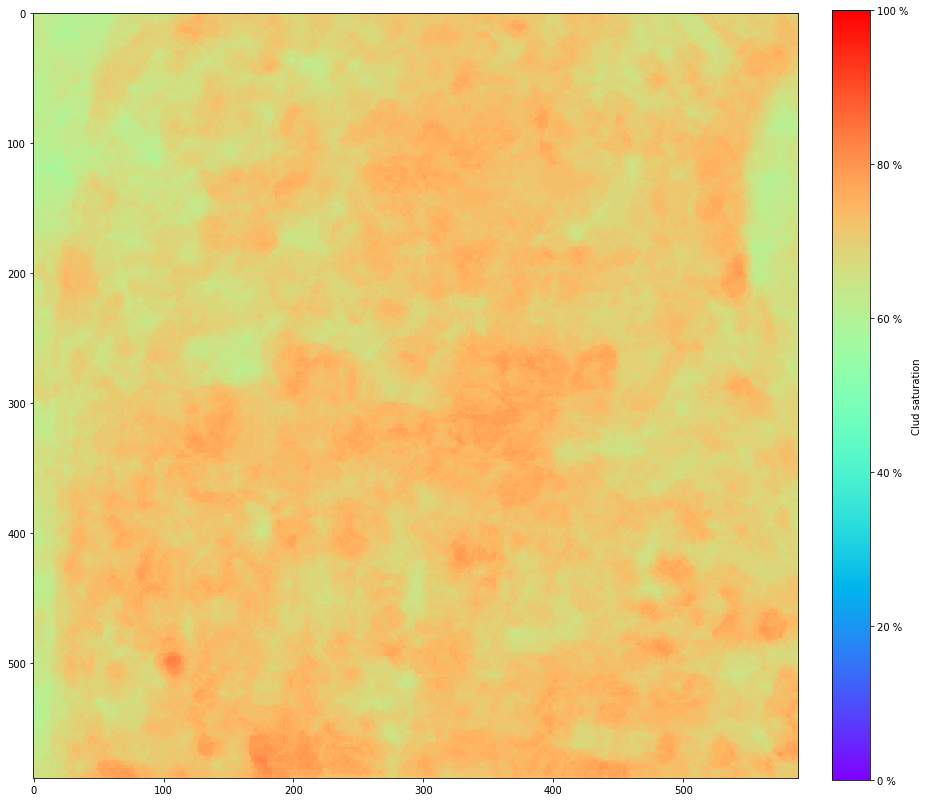

In [139]:
plot_cloud_mask(mask, cmap="rainbow", plot_cmap=True, cmap_frac=0.046)
plt.savefig("netherlands_cloud_saturation_cloud_scale_2", bbox_inches='tight', pad_inches=0)

In [23]:
# Collect sample indices (for the same area)
grayscale = cloud_sat.get_full_index_timeseries("MOISTURE-GRAYSCALE2")
ndvi = cloud_sat.get_full_index_timeseries("NDVI-NORMAL")
agri = cloud_sat.get_full_index_timeseries("AGRICULTURE")

In [30]:
# Layers from geopedia that currently work (Also see CloudSaturation.py)
# layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905', 'arable_land_2017':'ttl1917'}

# Get dataseries for same region (to reuse cloud data)
field, mask_t, nonzero = cloud_sat.get_tulip_mask("tulip_field_2016")
from Utils import *

Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1904&height=589&width=589&srs=EPSG:3857&bbox=524358.0140363087,6964349.630376049,534141.9536568124,6974133.5699965535


In [ ]:
x_ind, y_ind = nonzero[20]
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="rainbow")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
vis =cloud_sat.get_visible_filter(x_ind,y_ind)
#ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
#ka[cf] = 1
# White are clouds
#plot_timeseries(ka, cmap="gray")
#print(len(cf[0])/len(ndvi))
plot_timeseries_line(ndvi[:, x_ind, y_ind], vis, spec="go", datesp=dates)
plot_timeseries_line(ndvi[:, x_ind, y_ind], cf, spec="ro", new=False)
plt.savefig(f"ts/ndvi_index_full_netherlands_{x_ind},{y_ind}", bbox_inches='tight', pad_inches=0)
plot_timeseries_line(grayscale[:, x_ind, y_ind], vis, spec="go", datesp=dates)
plot_timeseries_line(grayscale[:, x_ind, y_ind], cf, spec="ro", new=False)
plt.savefig(f"ts/moisture_index_full_netherlands_{x_ind},{y_ind}", bbox_inches='tight', pad_inches=0)
plot_timeseries_line(agri[:, x_ind, y_ind], vis, spec="go", datesp=dates)
plot_timeseries_line(agri[:, x_ind, y_ind], cf, spec="ro", new=False)
plt.savefig(f"ts/agricultural_index_full_netherlands_{x_ind},{y_ind}", bbox_inches='tight', pad_inches=0)
x_ind, y_ind
#plot_timeseries_line(grayscale[:, x_ind, y_ind], vis, spec="bo")
#plot_timeseries_line(grayscale[:, x_ind, y_ind]*0, cf, spec="ro", new=False)

In [ ]:
x_ind, y_ind = 239, 120
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="rainbow")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
vis =cloud_sat.get_visible_filter(x_ind,y_ind)
#ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
#ka[cf] = 1
# White are clouds
#plot_timeseries(ka, cmap="gray")
#print(len(cf[0])/len(ndvi))
plot_timeseries_line(ndvi[:, x_ind, y_ind], vis, spec="go", datesp=dates)
plot_timeseries_line(ndvi[:, x_ind, y_ind]*0, cf, spec="ro", new=False)
plt.savefig(f"ts/ndvi_index_full_netherlands_no_tulip{x_ind},{y_ind}", bbox_inches='tight', pad_inches=0)
plot_timeseries_line(grayscale[:, x_ind, y_ind], vis, spec="go", datesp=dates)
plot_timeseries_line(grayscale[:, x_ind, y_ind]*0, cf, spec="ro", new=False)
plt.savefig(f"ts/moisture_index_full_netherlands_no_tulip{x_ind},{y_ind}", bbox_inches='tight', pad_inches=0)
plot_timeseries_line(agri[:, x_ind, y_ind], vis, spec="go", datesp=dates)
plot_timeseries_line(agri[:, x_ind, y_ind]*0, cf, spec="ro", new=False)
plt.savefig(f"ts/agricultural_index_full_netherlands_no_tulip{x_ind},{y_ind}", bbox_inches='tight', pad_inches=0)
#plot_timeseries_line(grayscale[:, x_ind, y_ind], vis, spec="bo")
#plot_timeseries_line(grayscale[:, x_ind, y_ind]*0, cf, spec="ro", new=False)
x_ind, y_ind

In [59]:
x_ind, y_ind = 239, 120
vis =cloud_sat.get_visible_filter(x_ind,y_ind)
print(np.mean(agri[:, x_ind, y_ind][vis]))
print(np.std(agri[:, x_ind, y_ind][vis]))
x_ind, y_ind = nonzero[20]
vis =cloud_sat.get_visible_filter(x_ind,y_ind)
print(np.mean(agri[:, x_ind, y_ind][vis]))
print(np.std(agri[:, x_ind, y_ind][vis]))

0.40929377
0.2247775
0.46438378
0.18816379


In [60]:
from bisect import bisect
def fill_density(data):
    last_date = datetime.datetime(day=7, month=3, year=2017)
    last_ind = dates
    

0.6120689655172413


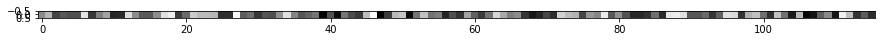

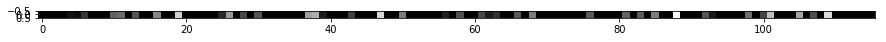

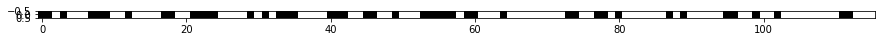

In [8]:
x_ind = 3
y_ind = 4
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="gray")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
ka[cf] = 1
# White are clouds
plot_timeseries(ka, cmap="gray")
print(len(cf[0])/len(ndvi))

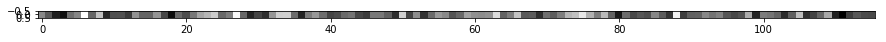

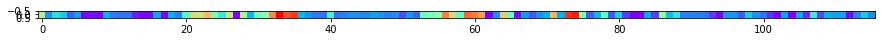

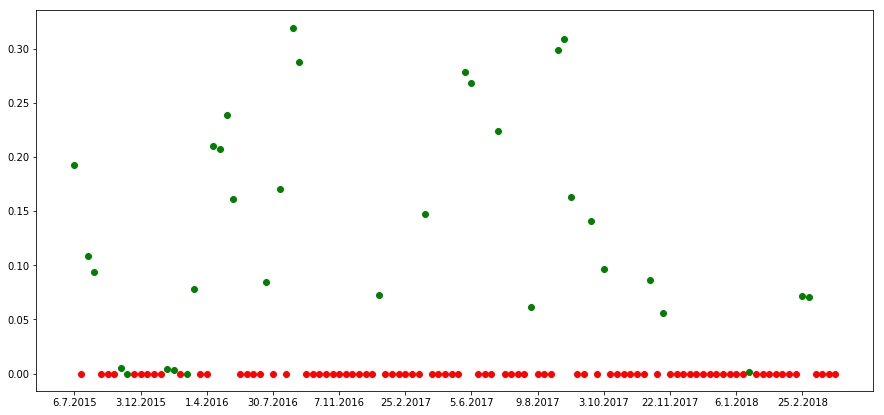

In [29]:
y_ind = 300
x_ind = 503
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="rainbow")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
vis =cloud_sat.get_visible_filter(x_ind,y_ind)
#ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
#ka[cf] = 1
# White are clouds
#plot_timeseries(ka, cmap="gray")
#print(len(cf[0])/len(ndvi))
plot_timeseries_line(ndvi[:, x_ind, y_ind], vis, spec="go", datesp=dates)
plot_timeseries_line(ndvi[:, x_ind, y_ind]*0, cf, spec="ro", new=False)
#plot_timeseries_line(grayscale[:, x_ind, y_ind], vis, spec="bo")
#plot_timeseries_line(grayscale[:, x_ind, y_ind]*0, cf, spec="ro", new=False)

In [340]:
# Dates of cloudy images
cloudy_dates = dates[cf]
dates

array([datetime.datetime(2015, 7, 6, 10, 53, 51),
       datetime.datetime(2015, 7, 16, 10, 50, 24),
       datetime.datetime(2015, 7, 26, 10, 50, 24),
       datetime.datetime(2015, 8, 5, 10, 50, 26),
       datetime.datetime(2015, 8, 15, 10, 50, 41),
       datetime.datetime(2015, 8, 25, 10, 50, 41),
       datetime.datetime(2015, 9, 4, 10, 50, 42),
       datetime.datetime(2015, 9, 14, 10, 50, 44),
       datetime.datetime(2015, 9, 24, 10, 50, 44),
       datetime.datetime(2015, 11, 13, 10, 53, 1),
       datetime.datetime(2015, 12, 3, 10, 54, 20),
       datetime.datetime(2015, 12, 3, 10, 58, 18),
       datetime.datetime(2015, 12, 23, 10, 58, 43),
       datetime.datetime(2016, 1, 2, 11, 1, 29),
       datetime.datetime(2016, 1, 12, 10, 56, 21),
       datetime.datetime(2016, 1, 12, 11, 6, 48),
       datetime.datetime(2016, 2, 1, 10, 52, 53),
       datetime.datetime(2016, 2, 11, 10, 51, 55),
       datetime.datetime(2016, 3, 12, 10, 50, 37),
       datetime.datetime(2016, 3, 22,

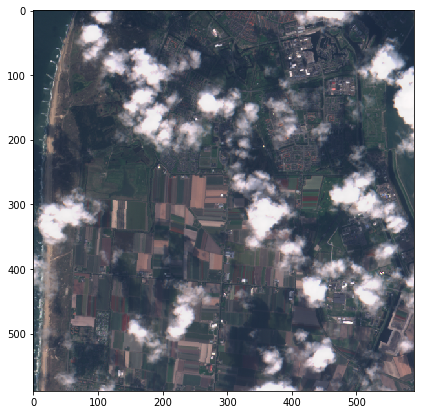

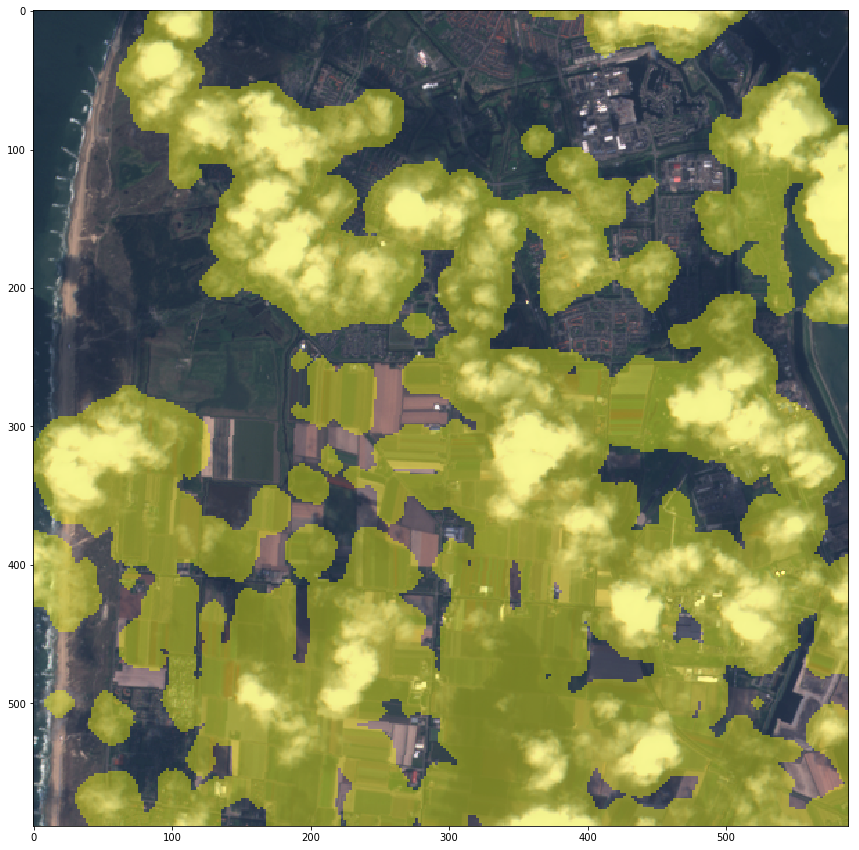

In [330]:
ind = 55
#grayscale[ind,[100,101,102,103, 104, 105, 106, 107, 108, 109, 110], 200] = 1
#plot_image(grayscale[ind])
#plot_image(ndvi[ind])
plot_image(true_c[ind])
plt.savefig("true_col_cloud_cloud_scale_2_ind_" + str(ind), bbox_inches='tight', pad_inches=0)
#plot_cloud_mask(cloud_masks[ind])
overlay_cloud_mask(true_c[ind], cloud_masks[ind])
plt.savefig("overlay_cloud_cloud_scale_2_ind_" + str(ind), bbox_inches='tight', pad_inches=0)

In [91]:
idd = "NDVI-GREEN-GRAYSCALE"
ndvi = cloud_sat.get_full_index_timeseries(idd)

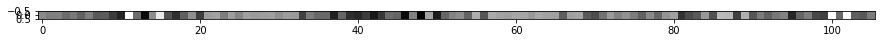

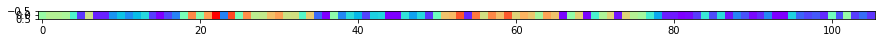

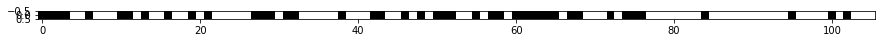

In [106]:
x_ind = 3
y_ind = 4
plot_timeseries(grayscale[:,x_ind,y_ind])
plot_timeseries(ndvi[:,x_ind,y_ind], cmap="rainbow")
# Filter with cloud data
cf=cloud_sat.get_cloud_filter(x_ind,y_ind)
ka = np.zeros(grayscale[:,x_ind,y_ind].shape)
ka[cf] = 1
# White are clouds
plot_timeseries(ka, cmap="gray")

In [333]:
grayscale[:,x_ind,y_ind].shape
dates[0], dates[-1]

(datetime.datetime(2015, 7, 6, 10, 53, 51),
 datetime.datetime(2018, 3, 17, 10, 53, 55))

In [108]:
grayscale.shape

(106, 723, 348)

In [109]:
cf

(array([  4,   5,   7,   8,   9,  12,  14,  15,  17,  18,  20,  22,  23,
         24,  25,  26,  30,  33,  34,  35,  36,  37,  39,  40,  41,  44,
         45,  47,  49,  53,  54,  56,  59,  66,  69,  70,  71,  73,  77,
         78,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  96,  97,  98,  99, 101, 103, 104, 105]),)

In [124]:
maskk, true_ck, bandsk, datesk, cloud_masksk = kocevje_cloud.get_cloud_saturation_mask()
grayscale_kocevje = kocevje_cloud.get_full_index_timeseries("MOISTURE-GRAYSCALE2")
ndvi_kocevje = kocevje_cloud.get_full_index_timeseries("NDVI-GREEN-GRAYSCALE")

Saved True color
Saved bands
Downloaded
Detected
(212, 314, 404)
(314, 404, 3)


In [205]:
grayscale[:,x_ind,y_ind]
dates

array([datetime.datetime(2015, 7, 6, 10, 53, 51),
       datetime.datetime(2015, 7, 16, 10, 50, 24),
       datetime.datetime(2015, 7, 26, 10, 50, 24),
       datetime.datetime(2015, 8, 5, 10, 50, 26),
       datetime.datetime(2015, 8, 15, 10, 50, 41),
       datetime.datetime(2015, 8, 25, 10, 50, 41),
       datetime.datetime(2015, 9, 4, 10, 50, 42),
       datetime.datetime(2015, 9, 14, 10, 50, 44),
       datetime.datetime(2015, 9, 24, 10, 50, 44),
       datetime.datetime(2015, 11, 13, 10, 53, 1),
       datetime.datetime(2015, 12, 3, 10, 54, 20),
       datetime.datetime(2015, 12, 3, 10, 58, 18),
       datetime.datetime(2015, 12, 23, 10, 58, 43),
       datetime.datetime(2016, 1, 2, 11, 1, 29),
       datetime.datetime(2016, 1, 12, 10, 56, 21),
       datetime.datetime(2016, 1, 12, 11, 6, 48),
       datetime.datetime(2016, 2, 1, 10, 52, 53),
       datetime.datetime(2016, 2, 11, 10, 51, 55),
       datetime.datetime(2016, 3, 12, 10, 50, 37),
       datetime.datetime(2016, 3, 22,

In [30]:
# Finding tulip fields

In [31]:
# Copided without shame from SenitinelHub, will update it when time permits

In [75]:
import pyproj
import sys
from DataRequest.DataRequest import TulipFieldRequest

def to_epsg3857(latlong_wgs84):
    epsg3857 = pyproj.Proj(init='epsg:3857')
    wgs84    = pyproj.Proj(init='EPSG:4326')
    return pyproj.transform(wgs84,epsg3857,latlong_wgs84[1],latlong_wgs84[0])

layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905', 'arable_land_2017':'ttl1917'}


In [76]:
bbox_3857_tulips = [to_epsg3857(point) for point in [(tulip_box[0], tulip_box[1]), (tulip_box[2], tulip_box[3])] ];

In [101]:
h = grayscale.shape[1]
w = grayscale.shape[2]
tulipFields = TulipFieldRequest(bbox=bbox_3857_tulips,width=w,height=h,crs=3857,layer=layers['tulip_field_2016'])
# Values [255,255,255] on some pixel mean, that there WAS NO field at that pixel
tulip_field = tulipFields.get_data()[0]
# Values 1 means NO tulips
tulip_field_mask = np.array(np.dot(tulip_field[...,:], [1,1,1])/765, dtype=int)
# tulip_field_mask = 1 - tulip_field_mask ## -> 1 tulips, 0 no tulips

Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1904&height=589&width=589&srs=EPSG:3857&bbox=524358.0140363087,6964349.630376049,534141.9536568124,6974133.5699965535


(589, 589)
(116, 589, 589, 3)


array([589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589,
       589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589,
       589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589,
       589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589,
       589, 589, 589, 589, 589, 589, 589, 589, 589, 572, 564, 559, 559,
       559, 559, 559, 559, 559, 559, 565, 565, 563, 563, 563, 563, 563,
       563, 559, 543, 535, 535, 494, 483, 477, 477, 500, 531, 544, 544,
       543, 555, 567, 567, 567, 567, 550, 540, 527, 520, 516, 519, 529,
       531, 531, 530, 530, 530, 525, 525, 525, 526, 526, 526, 526, 533,
       547, 558, 573, 569, 534, 513, 498, 497, 499, 499, 499, 499, 499,
       499, 499, 499, 500, 500, 501, 502, 497, 497, 497, 497, 499, 505,
       505, 505, 511, 523, 522, 500, 492, 492, 492, 492, 492, 493, 493,
       492, 492, 493, 493, 493, 499, 499, 499, 500, 515, 515, 536, 542,
       531, 520, 513, 505, 502, 500, 487, 476, 460, 444, 439, 43

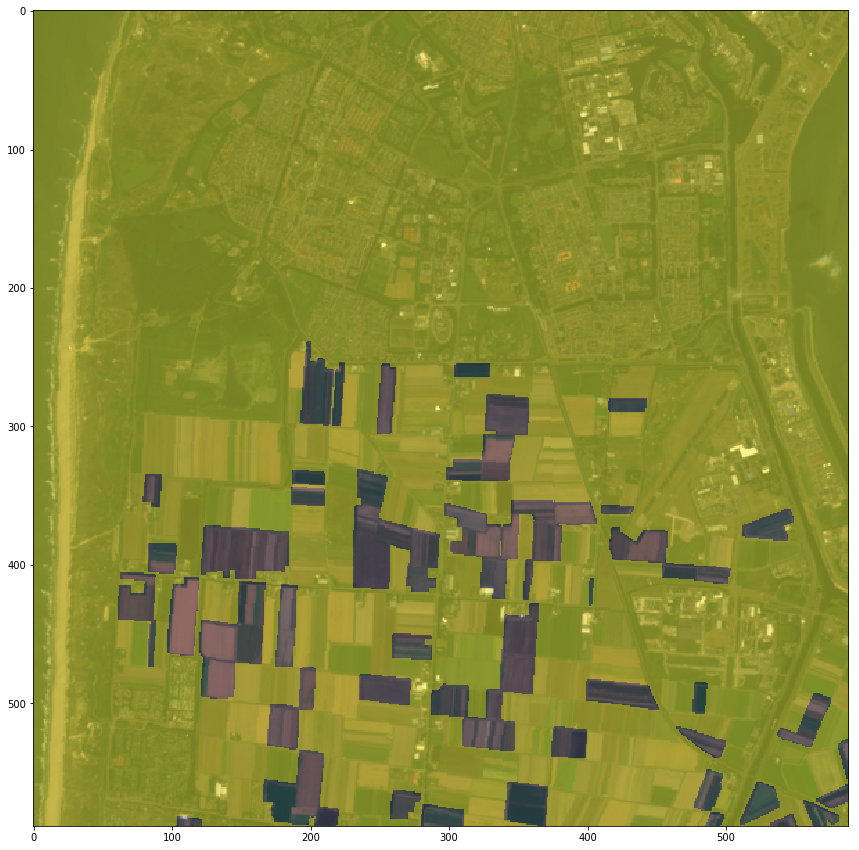

In [113]:
tulip_field_mask
print(tulip_field_mask.shape)
print(true_c.shape)
overlay_cloud_mask(true_c[0], tulip_field_mask)
sum(tulip_field_mask)

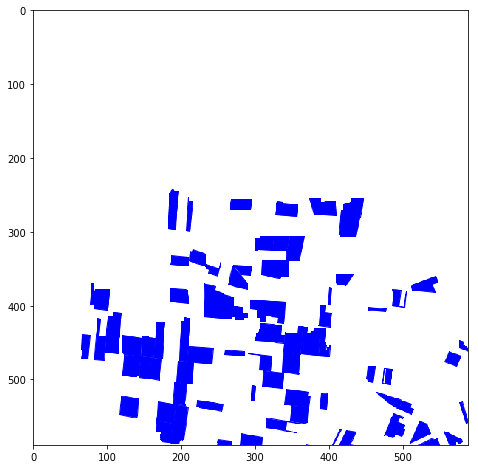

In [81]:
plt.figure(figsize=(8,8))
plt.imshow(tulip_field_mask)

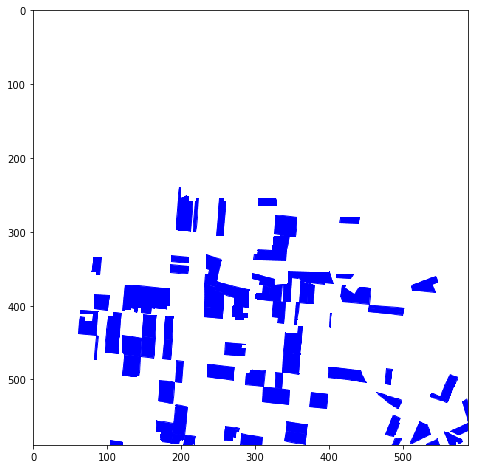

In [83]:
plt.figure(figsize=(8,8))
plt.imshow(tulip_field[0])

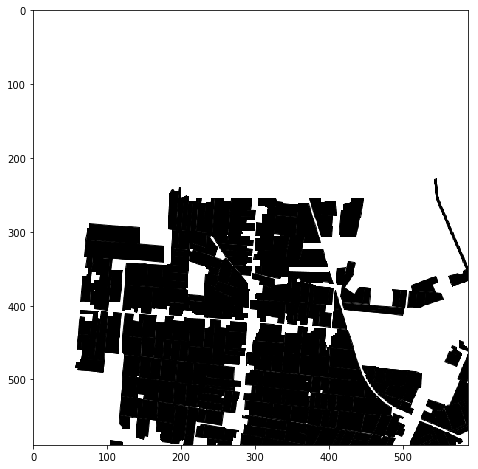

In [86]:
plt.figure(figsize=(8,8))
plt.imshow(tulip_field[0])

(array([0, 0, 0, 1]), array([1, 2, 3, 3]))

In [114]:
sum(sum(tulip_field_mask))

311965

In [117]:
rows, cols = np.nonzero(tulip_field_mask)
aa = tulip_field_mask[rows, cols]

In [118]:
aa

array([1, 1, 1, ..., 1, 1, 1])

In [119]:
len(aa)

311965

In [120]:
rows

array([  0,   0,   0, ..., 588, 588, 588])

In [123]:
a = np.array([[1,2,3,0], [4,0,0,5]])
r, c = np.nonzero(a)
r

array([0, 0, 0, 1, 1])

In [124]:
print(r)
print(c)

[0 0 0 1 1]
[0 1 2 0 3]


In [127]:
len(rows) == len(cols)

True

In [129]:
a[(0,0), (0,2)]

array([1, 3])

In [134]:
list(zip(*np.nonzero(a)))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 3)]

In [133]:
np.nonzero(a)

(array([0, 0, 0, 1, 1]), array([0, 1, 2, 0, 3]))

In [63]:
for date in dates:
    print(date.hour, date.minute)

10 53
10 50
10 50
10 50
10 50
10 50
10 50
10 50
10 50
10 53
10 54
10 58
10 58
11 1
10 56
11 6
10 52
10 51
10 50
10 52
10 50
10 50
10 50
10 53
10 53
10 55
10 55
10 53
10 50
10 52
10 53
10 50
10 53
10 55
10 54
10 50
10 50
10 50
10 50
10 51
10 52
10 53
10 54
10 54
10 54
10 55
10 53
10 53
10 54
10 56
10 50
10 50
10 54
10 50
10 53
10 56
10 53
10 50
10 53
10 55
10 53
10 55
10 53
10 53
10 56
10 54
10 50
10 55
10 53
10 53
10 55
10 55
10 54
10 52
10 50
10 55
10 53
10 53
10 50
10 50
10 50
10 50
10 53
10 50
10 51
10 51
10 52
10 52
10 53
10 53
10 53
10 56
10 53
10 54
10 55
10 54
10 54
10 54
10 54
10 54
10 54
10 55
10 55
10 54
10 53
10 54
10 53
10 51
10 53
10 55
10 50
10 50
10 50
10 53
10 53
10 50
10 50
10 55
10 53
